Import the necessary libraries

In [2]:
import os
import glob
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D,\
     MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
from keras.models import Model
from keras.models import Model
from keras.layers import Input, Conv2D, SeparableConv2D, MaxPooling2D,\
GlobalAveragePooling2D, Dense, Activation, BatchNormalization, Add


Inflating the image dataset into the google colab directory

In [8]:
#Extracts the contents of a zip archive to a specified directory.
!unzip "/content/drive/My Drive/archive.zip" -d "/content/"


Streaming output truncated to the last 5000 lines.
  inflating: /content/Data/train/COVID19/COVID19(228).jpg  
  inflating: /content/Data/train/COVID19/COVID19(229).jpg  
  inflating: /content/Data/train/COVID19/COVID19(23).jpg  
  inflating: /content/Data/train/COVID19/COVID19(230).jpg  
  inflating: /content/Data/train/COVID19/COVID19(231).jpg  
  inflating: /content/Data/train/COVID19/COVID19(232).jpg  
  inflating: /content/Data/train/COVID19/COVID19(233).jpg  
  inflating: /content/Data/train/COVID19/COVID19(234).jpg  
  inflating: /content/Data/train/COVID19/COVID19(235).jpg  
  inflating: /content/Data/train/COVID19/COVID19(236).jpg  
  inflating: /content/Data/train/COVID19/COVID19(237).jpg  
  inflating: /content/Data/train/COVID19/COVID19(238).jpg  
  inflating: /content/Data/train/COVID19/COVID19(239).jpg  
  inflating: /content/Data/train/COVID19/COVID19(24).jpg  
  inflating: /content/Data/train/COVID19/COVID19(240).jpg  
  inflating: /content/Data/train/COVID19/COVID19(24

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Graphical representation of dataset

In [9]:

class Dataset:
  """
  A class representing a dataset composed of directories with files.

    Attributes:
        directories (list): List of directory paths to count files in.
        file_counts (dict): Dictionary to store counts for each directory.
        test_covid (int): Count of COVID19 files in the test directory.
        test_normal (int): Count of NORMAL files in the test directory.
        test_pneumonia (int): Count of PNEUMONIA files in the test directory.
        train_covid (int): Count of COVID19 files in the train directory.
        train_normal (int): Count of NORMAL files in the train directory.
        train_pneumonia (int): Count of PNEUMONIA files in the train directory.
        total_covid (int): Total count of COVID19 files in both test and train
        directories.
        total_normal (int): Total count of NORMAL files in both test and train
        directories.
        total_pneumonia (int): Total count of PNEUMONIA files in both test and
        train directories.

    Methods:
        test(): Plot the count of each type in the test dataset.
        train(): Plot the count of each type in the train dataset.
        total(): Plot the total count in both test and train directories.
  """
  def __init__(self,):
    directories = ['/content/Data/test/COVID19',\
                '/content/Data/test/NORMAL',\
                  '/content/Data/test/PNEUMONIA',\
                '/content/Data/train/COVID19',\
                '/content/Data/train/NORMAL',\
                '/content/Data/train/PNEUMONIA']

    # Dictionary to store counts for each directory
    file_counts = {}

    # Loop through each directory
    for directory in directories:
        # Initialize count to 0
        count = 0
        # Walk through the directory and count files
        for dirpath, _, filenames in os.walk(directory):
            count += len(filenames)
        # Store the count in the dictionary
        file_counts[directory] = count

    # Assign values to variables
    self.test_covid = file_counts['/content/Data/test/COVID19']
    self.test_normal = file_counts['/content/Data/test/NORMAL']
    self.test_pneumonia = file_counts['/content/Data/test/PNEUMONIA']
    self.train_covid = file_counts['/content/Data/train/COVID19']
    self.train_normal = file_counts['/content/Data/train/NORMAL']
    self.train_pneumonia = file_counts['/content/Data/train/PNEUMONIA']

    self.total_covid = self.test_covid + self.train_covid
    self.total_normal = self.test_normal + self.train_normal
    self.total_pneumonia = self.test_pneumonia + self.train_pneumonia

  def test(self):
    # Plotting for test dataset
    plt.figure(figsize=(10, 5))
    test_bar = plt.bar(x=['COVID19', 'NORMAL', 'PNEUMONIA'],\
                      height=[self.test_covid, self.test_normal,\
                              self.test_pneumonia])
    plt.ylabel('Count')
    plt.title('Count of Each Type in Test Dataset')

    # Displaying values on top of each bar
    for bar in test_bar:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height, f'{height}',\
                ha='center', va='bottom')
    plt.show()

  def train(self):
    # Plotting for train dataset
    plt.figure(figsize=(10, 5))
    train_bar = plt.bar(x=['COVID19', 'NORMAL', 'PNEUMONIA'],\
                        height=[self.train_covid, self.train_normal,\
                                self.train_pneumonia])
    plt.ylabel('Count')
    plt.title('Count of Each Type in Train Dataset')

    # Displaying values on top of each bar
    for bar in train_bar:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height, f'{height}',\
                ha='center', va='bottom')

    plt.show()

  def total(self):
    # Plot size
    # Plotting
    plt.figure(figsize=(10, 5))
    bars = plt.bar(x=['COVID19', 'NORMAL', 'PNEUMONIA'],\
                  height=[self.total_covid, self.total_normal,\
                          self.total_pneumonia])
    plt.ylabel('Count')
    plt.title('Total count in test and train directory')

    # Displaying values on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height, f'{height}',\
                ha='center', va='bottom')

    plt.show()

Graphical representation of test dataset

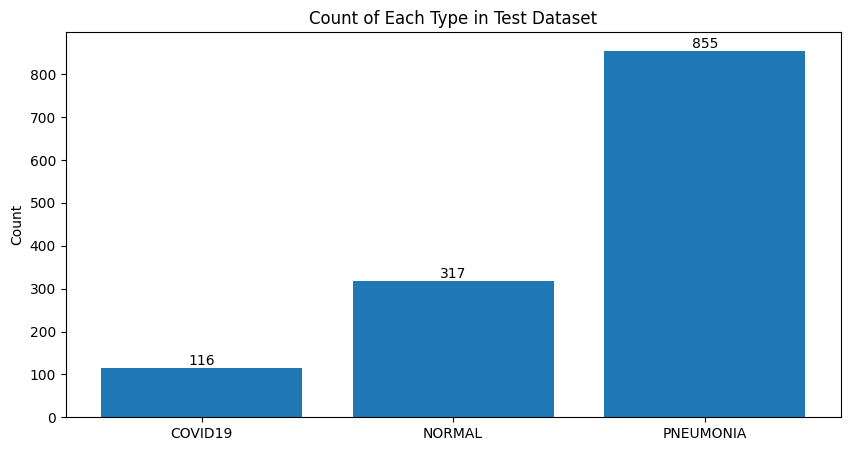

In [10]:
# Call the test method
dataset = Dataset()
dataset.test()

Graphical representation of train dataset

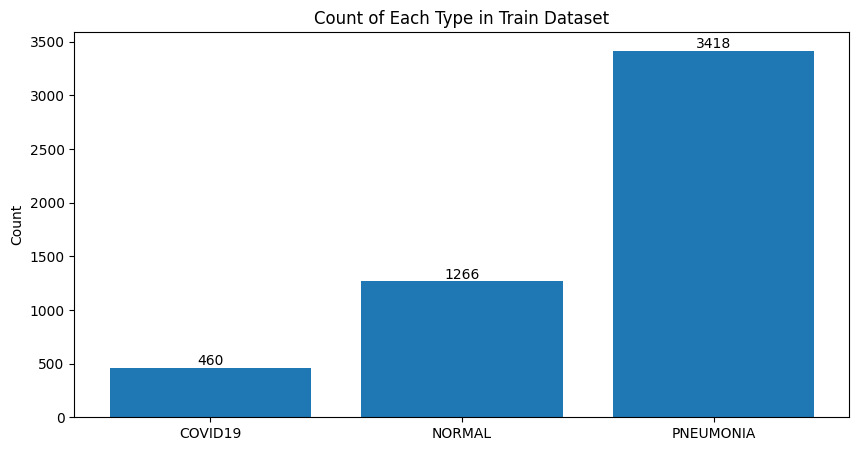

In [11]:
# Call the test method
dataset.train()

Graphical representation of total dataset

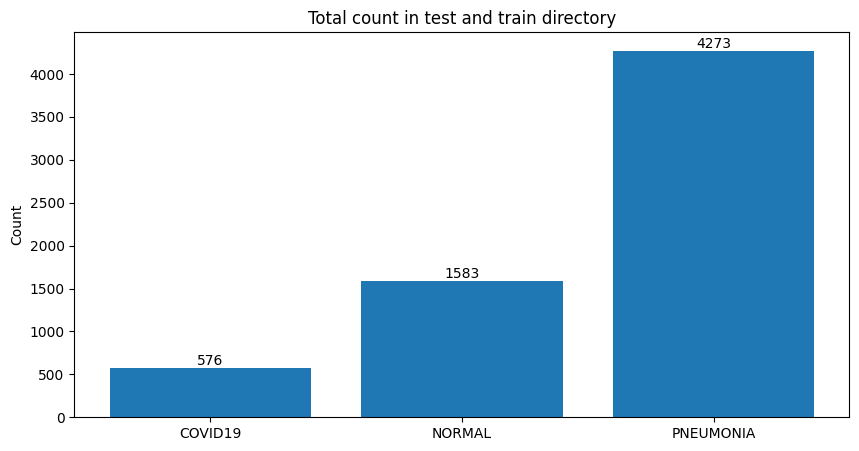

In [12]:
# Call the test method
dataset.total()

In [13]:
class Models():
  def __init__(self):
    self.imageDimensions1 = (180, 180, 1)
    self.target_size_val = (180, 180)

  def CNN_model(self,):
    model = Sequential()
    model.add(Conv2D(64, (3, 3), input_shape=self.imageDimensions1,\
                     activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))
    model.compile(Adam(learning_rate=0.001), loss='categorical_crossentropy',\
                  metrics=['accuracy'])
    return model

  def VGG16_model(self, input_shape=(224, 224, 3), num_classes=3):
      model = Sequential()

      # Block 1
      model.add(Conv2D(64, (3, 3), activation='relu', padding='same',\
                       input_shape=input_shape))
      model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
      model.add(MaxPooling2D((2, 2), strides=(2, 2)))

      # Block 2
      model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
      model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
      model.add(MaxPooling2D((2, 2), strides=(2, 2)))

      # Block 3
      model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
      model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
      model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
      model.add(MaxPooling2D((2, 2), strides=(2, 2)))

      # Block 4
      model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
      model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
      model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
      model.add(MaxPooling2D((2, 2), strides=(2, 2)))

      # Block 5
      model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
      model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
      model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
      model.add(MaxPooling2D((2, 2), strides=(2, 2)))

      # Fully connected layers
      model.add(Flatten())
      model.add(Dense(4096, activation='relu'))
      model.add(Dense(4096, activation='relu'))
      model.add(Dense(num_classes, activation='softmax'))

      model.compile(Adam(learning_rate=0.001), loss='categorical_crossentropy',\
                    metrics=['accuracy'])

      return model



  def Xception_model(self, input_shape=(299, 299, 3), num_classes=3):
    """
    Implementation of the Xception architecture.

    Args:
        input_shape (tuple): Shape of input image tensor.
        num_classes (int): Number of classes.

    """
    # Define input tensor
    input_tensor = Input(shape=input_shape)

    # Entry flow
    x = Conv2D(32, (3, 3), strides=(2, 2), use_bias=False,\
               name='block1_conv1')(input_tensor)
    x = BatchNormalization(name='block1_conv1_bn')(x)
    x = Activation('relu', name='block1_conv1_act')(x)
    x = Conv2D(64, (3, 3), use_bias=False, name='block1_conv2')(x)
    x = BatchNormalization(name='block1_conv2_bn')(x)
    x = Activation('relu', name='block1_conv2_act')(x)

    residual = Conv2D(128, (1, 1), strides=(2, 2), padding='same',\
                      use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(128, (3, 3), padding='same',\
                        use_bias=False, name='block2_sepconv1')(x)
    x = BatchNormalization(name='block2_sepconv1_bn')(x)
    x = Activation('relu', name='block2_sepconv2_act')(x)
    x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False,\
                        name='block2_sepconv2')(x)
    x = BatchNormalization(name='block2_sepconv2_bn')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same',\
                     name='block2_pool')(x)
    x = Add()([x, residual])

    residual = Conv2D(256, (1, 1), padding='same',\
                      use_bias=False)(x)
    residual = BatchNormalization()(residual)

    # Middle flow
    x = Activation('relu', name='block3_sepconv1_act')(x)
    x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False,\
                        name='block3_sepconv1')(x)
    x = BatchNormalization(name='block3_sepconv1_bn')(x)
    x = Activation('relu', name='block3_sepconv2_act')(x)
    x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False,\
                        name='block3_sepconv2')(x)
    x = BatchNormalization(name='block3_sepconv2_bn')(x)
    x = Activation('relu', name='block3_sepconv3_act')(x)
    x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False,\
                        name='block3_sepconv3')(x)
    x = BatchNormalization(name='block3_sepconv3_bn')(x)

    x = Add()([x, residual])

    residual = Conv2D(728, (1, 1), strides=(2, 2), padding='same',\
                      use_bias=False)(x)
    residual = BatchNormalization()(residual)

    # Exit flow
    x = Activation('relu', name='block4_sepconv1_act')(x)
    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False,\
                        name='block4_sepconv1')(x)
    x = BatchNormalization(name='block4_sepconv1_bn')(x)
    x = Activation('relu', name='block4_sepconv2_act')(x)
    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False,\
                        name='block4_sepconv2')(x)
    x = BatchNormalization(name='block4_sepconv2_bn')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same',\
                     name='block4_pool')(x)
    x = Add()([x, residual])

    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False,\
                        name='block5_sepconv1')(x)
    x = BatchNormalization(name='block5_sepconv1_bn')(x)
    x = Activation('relu', name='block5_sepconv2_act')(x)
    x = SeparableConv2D(1024, (3, 3), padding='same', use_bias=False,\
                        name='block5_sepconv2')(x)
    x = BatchNormalization(name='block5_sepconv2_bn')(x)

    x = GlobalAveragePooling2D(name='avg_pool')(x)
    output = Dense(num_classes, activation='softmax', name='predictions')(x)

    # Create model
    model = Model(inputs=input_tensor, outputs=output, name='xception')

    model.compile(Adam(learning_rate=0.001), loss='categorical_crossentropy',\
                  metrics=['accuracy'])

    return model

models = Models()

model1 = models.CNN_model()
print("CNN Model Summary:")
print(model1.summary())

model2 = models.VGG16_model()
print("\n\nVGG16 Model Summary:")
print(model2.summary())

model3 = models.Xception_model()
print("\n\nXception Model Summary:")
print(model3.summary())

CNN Model Summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 88, 88, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 88, 88, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 86, 86, 64)        36928     
                                                                 
 conv2d_3 (Conv2D)           (None, 84, 84, 64)        36928     
                                     

In [14]:
def preprocessing(img):
    img = img/255
    # TO NORMALIZE VALUES BETWEEN 0 AND 1 INSTEAD OF 0 TO 255
    return img

In [15]:
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10,
                            horizontal_flip = True,
                            validation_split = 0.3,
                            preprocessing_function = preprocessing)

In [16]:

class_names = ['normal', 'viral', 'covid']
root_dir = '/content/Data'
source_dirs = ['NORMAL', 'Viral Pneumonia', 'COVID-19']
imageDimesions = (180, 180, 1)
target_size_val = (180, 180)
target_size_val1 = (224, 224)

In [39]:
train_generator = datagen.flow_from_directory(os.path.join\
 (root_dir,'/content/Data/train'), subset = 'training',\
                                              color_mode = "grayscale",
                                              target_size = target_size_val,
                                              batch_size = 64)

train_generator2 = datagen.flow_from_directory(os.path.join\
 (root_dir, '/content/Data/train'), subset = 'training',\
                                               target_size = target_size_val1,
                                               batch_size = 64)

Found 3602 images belonging to 3 classes.
Found 3602 images belonging to 3 classes.


In [40]:
val_generator = datagen.flow_from_directory(os.path.join\
 (root_dir, '/content/Data/train'), subset = 'validation',\
                                            color_mode = "grayscale",
                                            target_size=target_size_val,
                                            batch_size=60)

val_generator2 = datagen.flow_from_directory(os.path.join\
 (root_dir, '/content/Data/train'), subset = 'validation',
                                             target_size=target_size_val1,
                                             batch_size=60)

Found 1542 images belonging to 3 classes.
Found 1542 images belonging to 3 classes.


In [20]:
# Early stopping is a method that allows you to specify an
# arbitrary large number of training epochs and stop training once
#the model performance stops improving on a hold out validation dataset.
cb1 = EarlyStopping(monitor="val_accuracy",
    min_delta = 0.001,
    patience = 10,
    verbose = 1,
    mode = "auto",
    baseline = None,
    restore_best_weights = True,
)

cb_list1 = [cb1]

In [21]:
cb2 = EarlyStopping(monitor="val_accuracy",
    min_delta = 0.001,
    patience = 10,
    verbose = 1,
    mode = "auto",
    baseline = None,
    restore_best_weights = True,
)

cb_list2 = [cb2]

In [22]:
cb3 = EarlyStopping(monitor="val_accuracy",
    min_delta = 0.001,
    patience = 10,
    verbose = 1,
    mode = "auto",
    baseline = None,
    restore_best_weights = True,
)

cb_list3 = [cb3]

In [28]:
history1 = model1.fit(train_generator,
                            steps_per_epoch= 10,
                            epochs=3,
                            validation_data=val_generator,
                            shuffle=True,
                            callbacks = cb_list1)

Epoch 1/3
10/10 [==============================] - 41s 4s/step - loss: 0.9134 - accuracy: 0.5875 - val_loss: 0.9003 - val_accuracy: 0.6647
Epoch 2/3
10/10 [==============================] - 45s 5s/step - loss: 0.8727 - accuracy: 0.6812 - val_loss: 0.8760 - val_accuracy: 0.6647
Epoch 3/3
10/10 [==============================] - 52s 6s/step - loss: 0.8374 - accuracy: 0.6609 - val_loss: 0.7511 - val_accuracy: 0.6673


In [ ]:
model1.save('/content/drive/My Drive/CNN_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
history2 = model2.fit(train_generator2,
                            steps_per_epoch= 10,
                            epochs=3,
                            validation_data=val_generator2,
                            shuffle=True,
                            callbacks = cb_list2)

Epoch 1/3
10/10 [==============================] - 118s 8s/step - loss: 2.4606 - accuracy: 0.5219 - val_loss: 0.8860 - val_accuracy: 0.6647
Epoch 2/3
10/10 [==============================] - 58s 6s/step - loss: 0.8928 - accuracy: 0.6484 - val_loss: 0.8668 - val_accuracy: 0.6647
Epoch 3/3
10/10 [==============================] - 58s 6s/step - loss: 0.8511 - accuracy: 0.6797 - val_loss: 0.8370 - val_accuracy: 0.6647


In [25]:
model2.save('/content/drive/My Drive/VGG16_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [31]:
history3 = model3.fit(train_generator2,
                            steps_per_epoch= 10,
                            epochs=3,
                            validation_data=val_generator2,
                            shuffle=True,
                            callbacks = cb_list3)

Epoch 1/3
10/10 [==============================] - 108s 8s/step - loss: 0.9823 - accuracy: 0.5875 - val_loss: 0.9675 - val_accuracy: 0.6647
Epoch 2/3
10/10 [==============================] - 58s 6s/step - loss: 0.6755 - accuracy: 0.7625 - val_loss: 0.8958 - val_accuracy: 0.6647
Epoch 3/3
10/10 [==============================] - 59s 6s/step - loss: 0.5330 - accuracy: 0.8156 - val_loss: 0.8615 - val_accuracy: 0.6647


In [ ]:
model3.save('/content/drive/My Drive/Xception_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


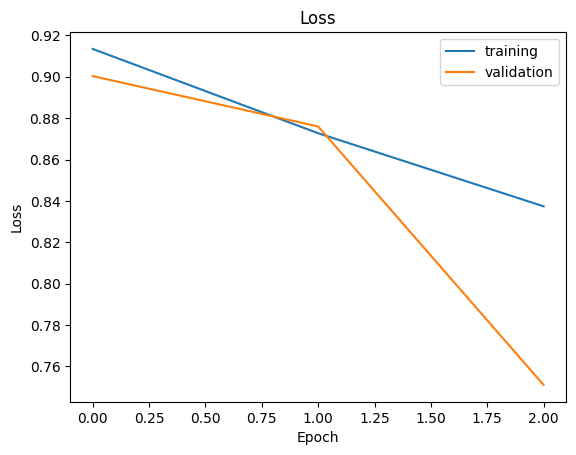

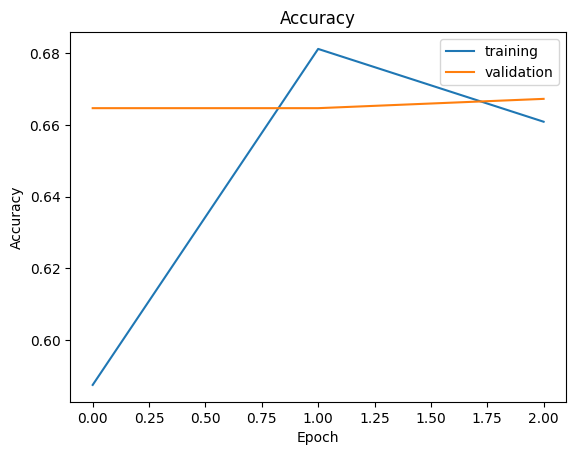

In [52]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.figure()  # Create figure 2
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()


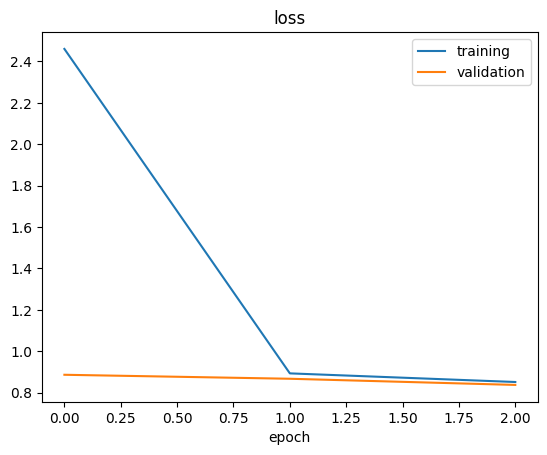

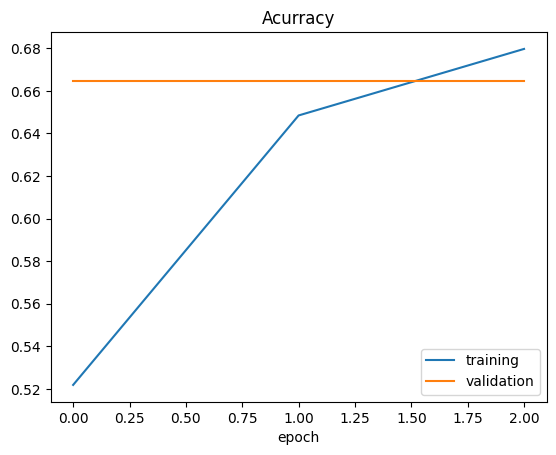

In [30]:
plt.figure(1)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.legend(['training','validation'])
plt.title('loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Acurracy')
plt.xlabel('epoch')
plt.show()

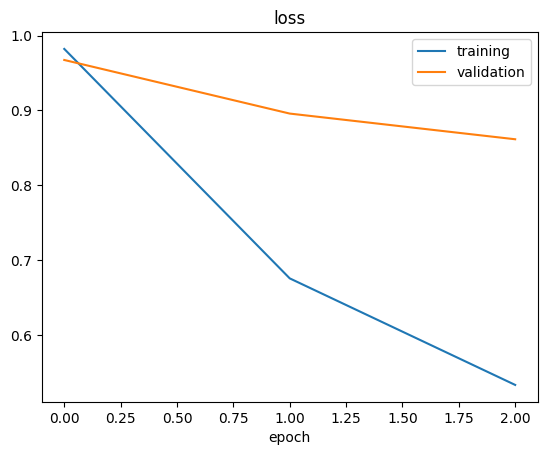

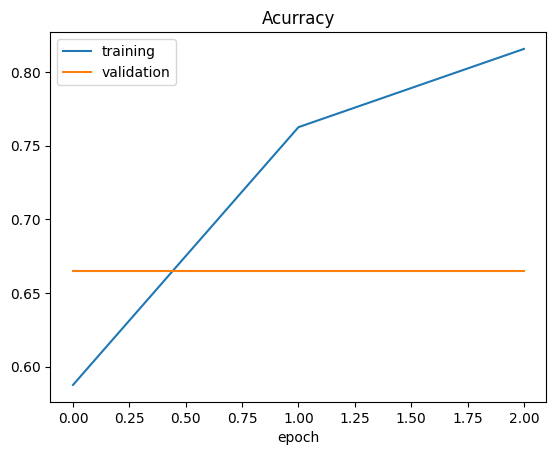

In [32]:
plt.figure(1)
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.legend(['training','validation'])
plt.title('loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Acurracy')
plt.xlabel('epoch')
plt.show()

Enter the X-ray image : /content/Data/test/COVID19/COVID19(480).jpg
1/1 [==============================] - 0s 19ms/step
Prediction for CNN is : 
Pneumonia


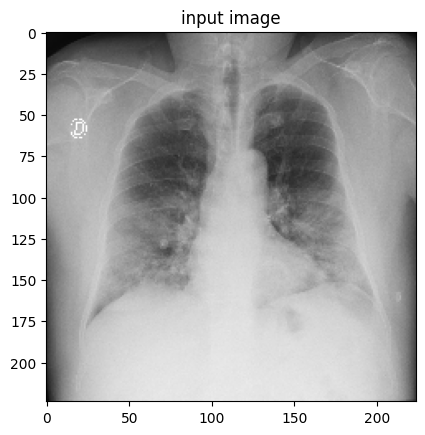

In [63]:
# 1. Reading Image

path = input('Enter the X-ray image : ')
#path = '/content/Data/train/NORMAL/NORMAL(1002).jpg'

img = cv2.imread(path)
img = cv2.resize(img, (180,180))
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = np.expand_dims(img, 2)
img = np.expand_dims(img, 0)

# 2. Predicting Results with X-ray Image
# {'covid': 0, 'normal': 1, 'pneumonia': 2}
pred1 = np.argmax(model1.predict(img))
print("Prediction for CNN is : ")
if pred1==0:
  print("Covid")
elif pred1==1:
  print("Normal")
else:
  print("Pneumonia")

# 3. To display the image

img = image.load_img(path, target_size=(224, 224))
img = image.img_to_array(img)
img = img.reshape((1, 224, 224, 3))
plt.imshow(img[0]/255, cmap = "gray")
plt.title("input image")
plt.show()
